# **Week10: Neural Collaborative Filtering for Movie Recommendations**



Aman Kumar

**References**

https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf - Neural collaborative filtering paper

https://keras.io/examples/structured_data/collaborative_filtering_movielens/

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from pathlib import Path
import matplotlib.pyplot as plt

## First, load the data and apply preprocessing

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


983040/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)


In [ ]:
movie2movie_encoded

In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


Random Train-Test split

In [ ]:
df = df.sample(frac=1, random_state=42) # randomly sample the data-set
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
x_train.shape

(90752, 2)

In [ ]:
y_train.shape

(90752,)

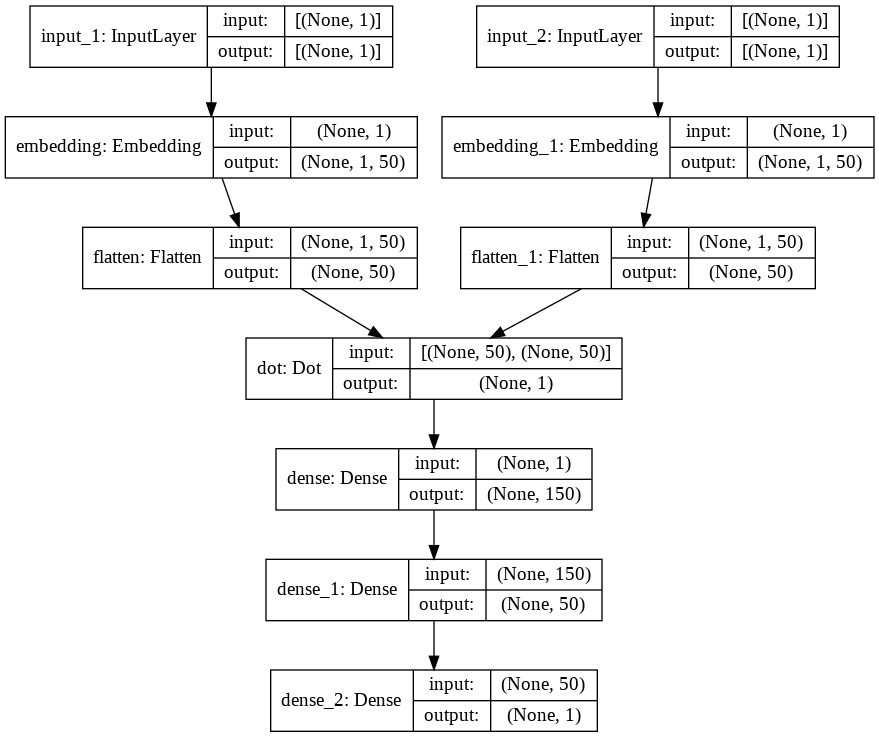

In [ ]:
## defining the model
embedding_size = 50

user_ips= layers.Input(shape=[1])
user_embedding = layers.Embedding(num_users,embedding_size,embeddings_initializer="he_normal",embeddings_regularizer=keras.regularizers.l2(1e-6))(user_ips)
# Embedding layer will create 610 vectors look-up table of 50 dimension each
user_vect= layers.Flatten()(user_embedding)

movie_ips= layers.Input(shape=[1])
movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer="he_normal",embeddings_regularizer=keras.regularizers.l2(1e-6))(movie_ips)
movie_vect= layers.Flatten()(movie_embedding)

prod = layers.dot(inputs=[user_vect, movie_vect],axes=1)

dense1= layers.Dense(150, activation='relu', kernel_initializer="he_normal")(prod)
dense2= layers.Dense(50, activation='relu',kernel_initializer="he_normal")(dense1)
dense3= layers.Dense(1,activation='relu')(dense2)

model = Model([user_ips, movie_ips], dense3)
model.compile(optimizer='adam',loss='mean_squared_error')

keras.utils.plot_model(model,show_shapes=True)

In [ ]:
history = model.fit([x_train[:,0], x_train[:,1]], y_train, batch_size=64,epochs=10,verbose=1)

Epoch 1/10
1418/1418 [==============================] - 10s 5ms/step - loss: 0.0748
Epoch 2/10
1418/1418 [==============================] - 6s 5ms/step - loss: 0.0452
Epoch 3/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0339
Epoch 4/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0293
Epoch 5/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0243
Epoch 6/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0223
Epoch 7/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0200
Epoch 8/10
1418/1418 [==============================] - 6s 5ms/step - loss: 0.0183
Epoch 9/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0177
Epoch 10/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.0164


In [ ]:
pred=model.predict([x_train[4:5,0], x_train[4:5,1]])
pred

array([[0.77350986]], dtype=float32)

Reading the movie file

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[ ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

In [ ]:
user_id

490

In [ ]:
movies_watched_by_user.head()

,userId,movieId,rating,timestamp,user,movie
79177,490,35836,3.0,1328145414,489,2126
79165,490,6539,3.0,1328145462,489,770
79154,490,4973,4.0,1334940456,489,1125
79162,490,6333,2.5,1328145443,489,767
79203,490,69757,4.0,1324370902,489,1059


In [ ]:
movies_not_watched

1            2
2            3
3            4
5            6
6            7
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 9629, dtype: int64

In [ ]:
## basically inner join between movies_not_watched and movie ids from df table (to be sure that the movie ids are not out of place)
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched

In [ ]:
movies_not_watched_index = [[movie2movie_encoded.get(x)] for x in movies_not_watched]  # get the indexes of the movies not watched by the user
movies_not_watched_index

In [ ]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

489

In [ ]:
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched_index))
user_movie_array ## 1st column is user_index and 2nd col is the list of movie indexes not watched by the user

array([[ 489, 5804],
       [ 489,  481],
       [ 489,    1],
       ...,
       [ 489, 3870],
       [ 489, 2989],
       [ 489, 7869]])

In [ ]:
ratings = model.predict([user_movie_array[:,0],user_movie_array[:,1]]).flatten()
ratings

array([0.42482403, 0.6214962 , 0.53197205, ..., 0.38191038, 0.62052035,
       0.33445033], dtype=float32)

In [ ]:
top_ratings_indices = ratings.argsort()[-10:][::-1] # indices of highest 10 ratings

In [ ]:
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched_index[x][0]) for x in top_ratings_indices]

In [ ]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 490
Movies with high ratings from user
--------------------------------
Three Colors: Red (Trois couleurs: Rouge) (1994) : Drama
Three Colors: Blue (Trois couleurs: Bleu) (1993) : Drama
8 1/2 (8½) (1963) : Drama|Fantasy
In the Mood For Love (Fa yeung nin wa) (2000) : Drama|Romance
Ikiru (1952) : Drama


In [ ]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


--------------------------------
Top 10 movie recommendations
--------------------------------
Outbreak (1995) : Action|Drama|Sci-Fi|Thriller
Blade Runner (1982) : Action|Sci-Fi|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Groundhog Day (1993) : Comedy|Fantasy|Romance
Starship Troopers (1997) : Action|Sci-Fi
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
Billy Elliot (2000) : Drama
Monsters, Inc. (2001) : Adventure|Animation|Children|Comedy|Fantasy
Incredibles, The (2004) : Action|Adventure|Animation|Children|Comedy
Hitchhiker's Guide to the Galaxy, The (2005) : Adventure|Comedy|Sci-Fi
